The purpose of the code is to predict customer response to marketing campaigns/

Question: Predict Customer Response to Marketing Campaigns
* The model predicts whether a customer will respond (1) or not respond (0) to a marketing campaign.
* Business Value: Helps companies target the right customers and improve campaign success rates.


# Step 1: Importing Required Libraries

* pandas, numpy → Data processing
* matplotlib, seaborn → Data visualization
* train_test_split, GridSearchCV → Splitting data & hyperparameter tuning
LogisticRegression, RandomForestClassifier → Machine learning models
* accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report → Model evaluation metrics
* OneHotEncoder, StandardScaler → Data preprocessing

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Step 2: Load the dataset and Data Quality Control

In [19]:
preprocessed_data_path = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(preprocessed_data_path)


df_transformed = df.copy()

# Drop Z_CostContact and Z_Revenue because the values are same across all records and not providing any meaningful information
columns_to_drop = ['Z_CostContact', 'Z_Revenue']
df_transformed = df_transformed.drop(columns=columns_to_drop)

# remove outliers in income
income_threshold = df_transformed['Income'].quantile(0.999)
income_outliers = df_transformed[df_transformed['Income'] > income_threshold]
print("Income Outliers removed:", income_outliers)
df_transformed = df_transformed[df_transformed['Income'] <= income_threshold]

# remove outliers in Year_Birth
birthyear_threshold = df_transformed['Year_Birth'].quantile(0.001)
birthyear_outliers = df_transformed[df_transformed['Year_Birth'] < birthyear_threshold]
print("Birth Year Outliers removed:", birthyear_outliers)
df_transformed = df_transformed[df_transformed['Year_Birth'] >= birthyear_threshold]

# remove outliers in Marital Status
marital_outliers = df_transformed[df_transformed['Marital_Status'].isin(['Absurd', 'YOLO'])]
print("Marital Status Outliers removed:", marital_outliers)
df_transformed = df_transformed[~df_transformed['Marital_Status'].isin(['Absurd', 'YOLO'])]


# fill empty income rows with the median value
median_income = df_transformed['Income'].median()
df_transformed['Income'].fillna(median_income, inplace=True)

# Handle date column first
df_transformed['Dt_Customer'] = pd.to_datetime(df_transformed['Dt_Customer'], format='%d-%m-%Y')

education_order = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

df_transformed['Education'] = df_transformed['Education'].map(education_order)

# Create mapping for marital status grouping
marital_mapping = {
    'Single': 'Single_Household',
    'Divorced': 'Single_Household',
    'Widow': 'Single_Household',
    'Alone': 'Single_Household',
    'Together': 'Couples',
    'Married': 'Couples'
}

# Apply mapping to create new grouped marital status
df_transformed['Marital_Status_Grouped'] = df_transformed['Marital_Status'].map(marital_mapping)

# Create one-hot encoding for the new merged categories
marital_dummies = pd.get_dummies(df_transformed['Marital_Status_Grouped'], prefix='Marital_Merged').astype(int)
df_transformed = pd.concat([df_transformed, marital_dummies], axis=1)

# Age calculation
df_transformed['Age'] = 2024 - df_transformed['Year_Birth']

# Total children calculation
df_transformed['Total_Children'] = df_transformed['Kidhome'] + df_transformed['Teenhome']

# Create more features
df_transformed['Total_Household_Size'] = (
    (df_transformed['Marital_Status_Grouped'] == 'Couples').astype(int) + 1 +
    df_transformed['Total_Children']
)

df_transformed['Total_Spending'] = df_transformed[['MntWines', 'MntFruits', 'MntMeatProducts',
                                                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

df_transformed['Total_Purchase_Num'] = df_transformed[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

df_transformed['Discount_Dependency'] = df_transformed['NumDealsPurchases'].div(df_transformed['Total_Purchase_Num']).replace([np.inf, -np.inf], 0).fillna(0)
# Remove unreasonable data
df_transformed = df_transformed[df_transformed['Discount_Dependency'] < 1]

df_transformed['Loyalty_Months'] = ((pd.to_datetime('today') - df_transformed['Dt_Customer']).dt.days // 30)

df_transformed['Campaign_Response_Rate'] = df_transformed[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1) / 6

# Drop original categorical columns if no longer needed
columns_to_drop = ['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Marital_Status','Marital_Status_Grouped']
df_transformed = df_transformed.drop(columns=columns_to_drop)

# Rearrange the data frame
features = [
    # Purchase Data
    'Total_Spending', 'MntWines', 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
    'Total_Purchase_Num', 'NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'Discount_Dependency',

    # Demographic Features
    'Income','Age','Education', 'Marital_Merged_Couples', 'Marital_Merged_Single_Household','Total_Household_Size','Total_Children',

    # Promotion Responsiveness - was 'Campaign_Response_Rate',
   'Response',

    # Satisfaction and Loyalty
    'Complain', 'Loyalty_Months', 'Recency', 'NumWebVisitsMonth'
]
df_transformed = df_transformed[features]


df = df_transformed.copy()
df_transformed.head(5)

Income Outliers removed:         ID  Year_Birth   Education Marital_Status    Income  Kidhome  \
617   1503        1976         PhD       Together  162397.0        1   
687   1501        1982         PhD        Married  160803.0        0   
2233  9432        1977  Graduation       Together  666666.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  \
617          1  03-06-2013       31        85  ...                    0   
687          0  04-08-2012       21        55  ...                   28   
2233         0  02-06-2013       23         9  ...                    1   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
617                   1                  1             0             0   
687                   1                  0             0             0   
2233                  3                  6             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
617              0 

<ipython-input-19-6945f93c61d1>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transformed['Income'].fillna(median_income, inplace=True)


,Total_Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Total_Purchase_Num,NumWebPurchases,NumCatalogPurchases,...,Education,Marital_Merged_Couples,Marital_Merged_Single_Household,Total_Household_Size,Total_Children,Response,Complain,Loyalty_Months,Recency,NumWebVisitsMonth
0,1617,635,88,546,172,88,88,22,8,10,...,2,0,1,1,0,1,0,152,58,7
1,27,11,1,6,2,1,6,4,1,1,...,2,0,1,3,2,0,0,134,38,5
2,776,426,49,127,111,21,42,20,8,2,...,2,1,0,2,0,0,0,140,26,4
3,53,11,4,20,10,3,5,6,2,0,...,2,1,0,3,1,0,0,135,26,6
4,422,173,43,118,46,27,15,14,5,3,...,4,1,0,3,1,0,0,135,94,5


# Step 3: Define Features (X) and Target (y)
* X → Independent variables (all columns except "Response").
* y → Target variable ("Response") → 1 (Responded), 0 (Not Responded).

In [20]:
#X = df.drop(columns=["Campaign_Response_Rate"])  # Features excluding target variable
#y = df["Campaign_Response_Rate"]  # Target variable

X = df.drop(columns=["Response"])  # Features excluding target variable
y = df["Response"]  # Target variable

print("----- X ---------")
print(X)
print("----- y ---------")
print(y)

----- X ---------
      Total_Spending  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0               1617       635         88              546              172   
1                 27        11          1                6                2   
2                776       426         49              127              111   
3                 53        11          4               20               10   
4                422       173         43              118               46   
...              ...       ...        ...              ...              ...   
2235            1341       709         43              182               42   
2236             444       406          0               30                0   
2237            1241       908         48              217               32   
2238             843       428         30              214               80   
2239             172        84          3               61                2   

      MntSweetProducts  MntGoldPr

# Step 5: Split Data into Training and Testing Sets

* Splits the dataset into 80% training and 20% testing.
* Stratify=y ensures that both training and test sets have the same proportion of class labels.


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.dtypes)
print(X_train.head(5))

Total_Spending                       int64
MntWines                             int64
MntFruits                            int64
MntMeatProducts                      int64
MntFishProducts                      int64
MntSweetProducts                     int64
MntGoldProds                         int64
Total_Purchase_Num                   int64
NumWebPurchases                      int64
NumCatalogPurchases                  int64
NumStorePurchases                    int64
Discount_Dependency                float64
Income                             float64
Age                                  int64
Education                            int64
Marital_Merged_Couples               int64
Marital_Merged_Single_Household      int64
Total_Household_Size                 int64
Total_Children                       int64
Complain                             int64
Loyalty_Months                       int64
Recency                              int64
NumWebVisitsMonth                    int64
dtype: obje

# Step 6: Create a Standard Scaler

* Creates an instance of StandardScaler, which normalizes numerical features by scaling them to have a mean of 0 and a standard deviation of 1.
* Specifies categorical or binary columns that should not be scaled (e.g., one-hot encoded marital status and complaint response).
* Selects all numeric columns from the training data.
* Filters out the excluded columns to ensure only relevant numerical features are scaled.
* Creates a copy of X_train to store the scaled values.
* Fits and transforms numerical features using StandardScaler.
* Creates a copy of X_test to store the scaled values.
* Uses the same scaling parameters (fitted on X_train) to transform X_test.
* Displays the first 5 rows of the scaled test dataset to verify that the transformation was applied correctly.

In [22]:
scaler = StandardScaler()
columns_to_exclude = ['Marital_Merged_Single_Household','Marital_Merged_Couples', 'Complain']

numerical_columns = X_train.select_dtypes(include=['number']).columns
columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

# Scale numerical features
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

X_test_scaled.head(5)


,Total_Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Total_Purchase_Num,NumWebPurchases,NumCatalogPurchases,...,Age,Education,Marital_Merged_Couples,Marital_Merged_Single_Household,Total_Household_Size,Total_Children,Complain,Loyalty_Months,Recency,NumWebVisitsMonth
808,0.699231,0.937397,0.637354,0.052736,-0.257675,-0.233974,1.772574,0.079887,-0.384081,-0.220519,...,-0.261362,-0.454966,1,0,1.548200,1.404797,0,0.608614,1.319046,1.097546
1544,0.313589,0.960830,-0.658616,-0.227734,-0.496355,-0.479289,-0.257817,1.196561,1.859325,-0.220519,...,0.422798,-0.454966,0,1,-0.647678,0.070391,0,1.499800,1.598651,0.682226
1370,-0.602723,-0.468611,-0.511903,-0.508204,-0.477995,-0.454757,-0.514080,-0.338866,-0.010180,-0.565789,...,-0.517922,-0.454966,0,1,-0.647678,0.070391,0,-1.470818,1.633602,-0.148412
1523,-0.914203,-0.831830,-0.585260,-0.655116,-0.624875,-0.626478,-0.790056,-1.036788,-0.757982,-0.911059,...,-0.346882,1.540319,1,0,0.450261,0.070391,0,-1.470818,-1.232353,0.682226
120,0.094399,0.049854,0.515093,-0.147600,0.036085,1.115256,0.097008,0.777808,0.737622,-0.220519,...,1.363518,0.542677,1,0,0.450261,0.070391,0,0.163022,0.550131,-0.563732


# Step 7: Train Logistic Regression Model

* Creates an instance of Logistic Regression, a classification algorithm.
max_iter=1000 → Sets the maximum number of iterations to 1000 to ensure the model converges.
* C=0.1 → Controls L2 regularization (inverse of regularization strength) to prevent overfitting.
random_state=42 → Ensures consistent results every time the model is trained.
* Fits (trains) the Logistic Regression model on the training dataset (X_train_scaled, y_train).
* Learns the relationship between input features (X_train_scaled) and the target variable (y_train).
* Finds optimal weights (coefficients) for each feature to separate classes (e.g., responders vs. non-responders).

In [24]:
log_reg_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42)

# Step 8: Train Random Forest Model

* Creates an instance of Random Forest, an ensemble learning algorithm that combines multiple decision trees for classification.
* n_estimators=100 → Uses 100 decision trees in the forest to improve prediction stability.
* max_depth=10 → Limits the depth of each tree to prevent overfitting.
* max_features="sqrt" → Each tree randomly considers only the square root of the total features at each split, improving diversity and reducing correlation.
random_state=42 → Ensures reproducibility by setting a fixed seed.
* Fits (trains) the Random Forest model on the training dataset (X_train_scaled, y_train).
* Creates multiple decision trees and combines their results to make more accurate predictions.
* Learns patterns in the data by splitting features into decision rules.

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

# Step 9: Make Predictions on Logistic Regression and Random Forest Models.

In [26]:
#y_pred_logreg = log_reg_model.predict(X_test)
#y_pred_rf = rf_model.predict(X_test)

y_pred_logreg = log_reg_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)


# Step 10: Evaluate Models

In [47]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
# find out what f1_score and roc_auc do!
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
classification_report_best_rf = classification_report(y_test, y_pred_best_rf)

# Step 11.1: Hyperparameter Tuning on Logistic Regression

In [36]:
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_params, cv=5)
log_reg_grid.fit(X_train_scaled, y_train)
best_log_reg = log_reg_grid.best_estimator_

# Step 11.2: Hyperparameter Tuning on Random Forest


In [37]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

# Train Optimized Models
best_log_reg.fit(X_train_scaled, y_train)
y_pred_best_logreg = best_log_reg.predict(X_test_scaled)

best_rf.fit(X_train_scaled, y_train)
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Step 12: Predicting Logistic Regression Model

In [38]:
best_log_reg.fit(X_train_scaled, y_train)
y_pred_best_logreg = best_log_reg.predict(X_test_scaled)

# Step 13: Generate the Numbers.


In [41]:
accuracy_best_logreg = accuracy_score(y_test, y_pred_best_logreg)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_logreg = precision_score(y_test, y_pred_best_logreg)
recall_best_logreg = recall_score(y_test, y_pred_best_logreg)
f1_best_logreg = f1_score(y_test, y_pred_best_logreg)
roc_auc_best_logreg = roc_auc_score(y_test, y_pred_best_logreg)
conf_matrix_best_logreg = confusion_matrix(y_test, y_pred_best_logreg)
classification_report_best_logreg = classification_report(y_test, y_pred_best_logreg)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
classification_report_best_rf = classification_report(y_test, y_pred_best_rf)

# Step 14: Print Final Results

Prints key performance metrics for both models.

Logistic Regression Optimized Accuracy: 0.8616780045351474
Random Forest Optimized Accuracy: 0.8752834467120182
Logistic Regression Precision: 0.6
Random Forest Precision: 0.8235294117647058
Logistic Regression Recall: 0.22727272727272727
Random Forest Recall: 0.21212121212121213
Logistic Regression F1 Score: 0.32967032967032966
Random Forest F1 Score: 0.3373493975903614
Logistic Regression ROC AUC: 0.6003030303030303
Random Forest ROC AUC: 0.6020606060606061

Logistic Regression Confusion Matrix:
 [[365  10]
 [ 51  15]]

Random Forest Confusion Matrix:
 [[372   3]
 [ 52  14]]

Logistic Regression Optimized Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       375
           1       0.60      0.23      0.33        66

    accuracy                           0.86       441
   macro avg       0.74      0.60      0.63       441
weighted avg       0.84      0.86      0.83       441


Random Forest Optimized Report:
               p

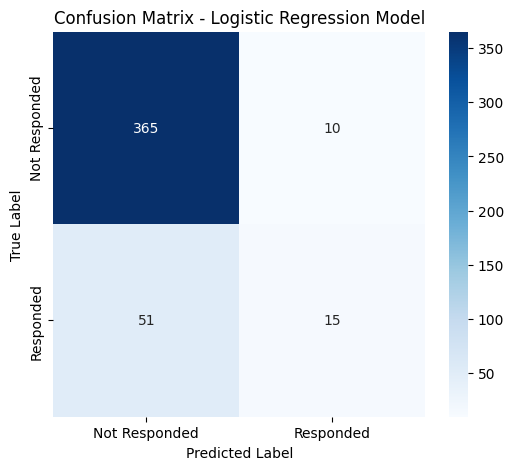

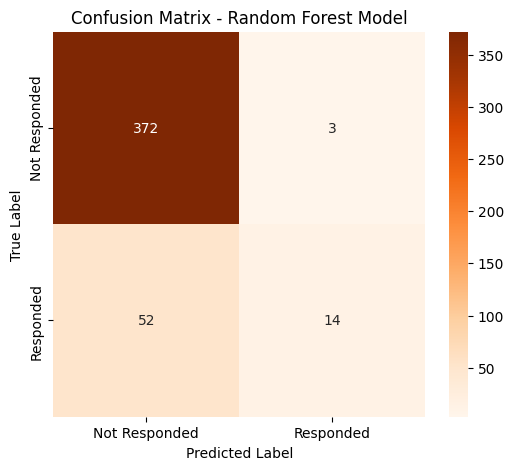

In [46]:
print("Logistic Regression Optimized Accuracy:", accuracy_best_logreg)
print("Random Forest Optimized Accuracy:", accuracy_best_rf)
print("Logistic Regression Precision:", precision_best_logreg)
print("Random Forest Precision:", precision_best_rf)
print("Logistic Regression Recall:", recall_best_logreg)
print("Random Forest Recall:", recall_best_rf)
print("Logistic Regression F1 Score:", f1_best_logreg)
print("Random Forest F1 Score:", f1_best_rf)
print("Logistic Regression ROC AUC:", roc_auc_best_logreg)
print("Random Forest ROC AUC:", roc_auc_best_rf)
print("\nLogistic Regression Confusion Matrix:\n", conf_matrix_best_logreg)
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_best_rf)
print("\nLogistic Regression Optimized Report:\n", classification_report_best_logreg)
print("\nRandom Forest Optimized Report:\n", classification_report_best_rf)

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

# Step 15: Conclusion

**Accuracy & General Performance**

Overall Accuracy:

* Logistic Regression: 86.17%
* Random Forest: 87.53%
* Conclusion: Both models perform well in overall accuracy, but this is mainly because they excel at identifying non-responders (Class 0).

**Class Imbalance Issue (Bias Toward Non-Responders)**
* Both models struggle with correctly identifying responders (Class 1):
* Low Recall (Logistic Regression: 22.7%, Random Forest: 21.2%)
* This means the models fail to correctly identify most actual responders.
* Out of 66 actual responders, Logistic Regression only correctly predicts 15, and Random Forest only 14.
* Precision is better (Logistic Regression: 60%, Random Forest: 82%)
When the models predict a positive response (Class 1), it’s more likely to be correct.

***Implication***: The model is very conservative in predicting responders. It is biased towards predicting non-responders because the dataset contains far more non-responders (375) than responders (66).

**Confusion Matrix Interpretation**

1.   Logistic Regression
* Correctly predicts 365 non-responders (True Negatives) out of 375.
* Misclassifies 51 responders as non-responders (False Negatives) → Misses 77% of actual responders.
* Only correctly identifies 15 responders (True Positives).

2.   Random Forest Classifier
* Correctly predicts 372 non-responders (True Negatives), slightly better than Logistic Regression.
* Misses 52 responders (False Negatives).
* Identifies 14 responders correctly (True Positives).

***Implication***: False negatives are a big issue – these are people who would have responded, but the model failed to identify them. Companies could lose potential customers because the model does not recommend targeting them with campaigns.

**ROC AUC Score (Ability to Differentiate Classes)**
* Logistic Regression: 0.60
* Random Forest: 0.60
* Conclusion: A random classifier would score 0.50, meaning our models are only slightly better than random guessing when distinguishing between responders and non-responders.

**Final Conclusion**
* The model is good at predicting who will NOT respond but struggles to predict actual responders.
* Companies using this model may miss a lot of potential customers (false negatives).
* This suggests we need improvements to increase recall (correctly predicting more responders).

# Retrospective: The Below is the Entire Code

Income Outliers removed:         ID  Year_Birth   Education Marital_Status    Income  Kidhome  \
617   1503        1976         PhD       Together  162397.0        1   
687   1501        1982         PhD        Married  160803.0        0   
2233  9432        1977  Graduation       Together  666666.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  \
617          1  03-06-2013       31        85  ...                    0   
687          0  04-08-2012       21        55  ...                   28   
2233         0  02-06-2013       23         9  ...                    1   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
617                   1                  1             0             0   
687                   1                  0             0             0   
2233                  3                  6             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
617              0 

<ipython-input-48-3937c0f624a7>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transformed['Income'].fillna(median_income, inplace=True)


Logistic Regression Optimized Accuracy: 0.8616780045351474
Random Forest Optimized Accuracy: 0.8752834467120182
Logistic Regression Precision: 0.6
Random Forest Precision: 0.8235294117647058
Logistic Regression Recall: 0.22727272727272727
Random Forest Recall: 0.21212121212121213
Logistic Regression F1 Score: 0.32967032967032966
Random Forest F1 Score: 0.3373493975903614
Logistic Regression ROC AUC: 0.6003030303030303
Random Forest ROC AUC: 0.6020606060606061

Logistic Regression Confusion Matrix:
 [[365  10]
 [ 51  15]]

Random Forest Confusion Matrix:
 [[372   3]
 [ 52  14]]

Logistic Regression Optimized Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       375
           1       0.60      0.23      0.33        66

    accuracy                           0.86       441
   macro avg       0.74      0.60      0.63       441
weighted avg       0.84      0.86      0.83       441


Random Forest Optimized Report:
               p

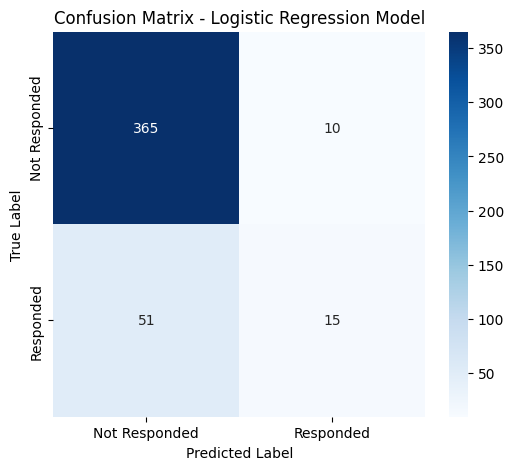

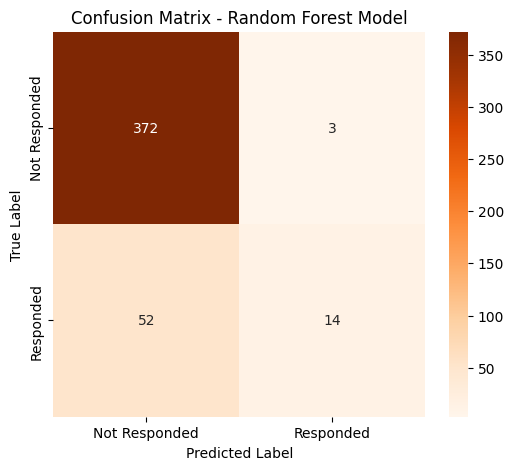

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

preprocessed_data_path = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(preprocessed_data_path)


df_transformed = df.copy()

# Drop Z_CostContact and Z_Revenue because the values are same across all records and not providing any meaningful information
columns_to_drop = ['Z_CostContact', 'Z_Revenue']
df_transformed = df_transformed.drop(columns=columns_to_drop)

# remove outliers in income
income_threshold = df_transformed['Income'].quantile(0.999)
income_outliers = df_transformed[df_transformed['Income'] > income_threshold]
print("Income Outliers removed:", income_outliers)
df_transformed = df_transformed[df_transformed['Income'] <= income_threshold]

# remove outliers in Year_Birth
birthyear_threshold = df_transformed['Year_Birth'].quantile(0.001)
birthyear_outliers = df_transformed[df_transformed['Year_Birth'] < birthyear_threshold]
print("Birth Year Outliers removed:", birthyear_outliers)
df_transformed = df_transformed[df_transformed['Year_Birth'] >= birthyear_threshold]

# remove outliers in Marital Status
marital_outliers = df_transformed[df_transformed['Marital_Status'].isin(['Absurd', 'YOLO'])]
print("Marital Status Outliers removed:", marital_outliers)
df_transformed = df_transformed[~df_transformed['Marital_Status'].isin(['Absurd', 'YOLO'])]


# fill empty income rows with the median value
median_income = df_transformed['Income'].median()
df_transformed['Income'].fillna(median_income, inplace=True)

# Handle date column first
df_transformed['Dt_Customer'] = pd.to_datetime(df_transformed['Dt_Customer'], format='%d-%m-%Y')

education_order = {
    'Basic': 0,
    '2n Cycle': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}

df_transformed['Education'] = df_transformed['Education'].map(education_order)

# Create mapping for marital status grouping
marital_mapping = {
    'Single': 'Single_Household',
    'Divorced': 'Single_Household',
    'Widow': 'Single_Household',
    'Alone': 'Single_Household',
    'Together': 'Couples',
    'Married': 'Couples'
}

# Apply mapping to create new grouped marital status
df_transformed['Marital_Status_Grouped'] = df_transformed['Marital_Status'].map(marital_mapping)

# Create one-hot encoding for the new merged categories
marital_dummies = pd.get_dummies(df_transformed['Marital_Status_Grouped'], prefix='Marital_Merged').astype(int)
df_transformed = pd.concat([df_transformed, marital_dummies], axis=1)

# Age calculation
df_transformed['Age'] = 2024 - df_transformed['Year_Birth']

# Total children calculation
df_transformed['Total_Children'] = df_transformed['Kidhome'] + df_transformed['Teenhome']

# Create more features
df_transformed['Total_Household_Size'] = (
    (df_transformed['Marital_Status_Grouped'] == 'Couples').astype(int) + 1 +
    df_transformed['Total_Children']
)

df_transformed['Total_Spending'] = df_transformed[['MntWines', 'MntFruits', 'MntMeatProducts',
                                                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

df_transformed['Total_Purchase_Num'] = df_transformed[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

df_transformed['Discount_Dependency'] = df_transformed['NumDealsPurchases'].div(df_transformed['Total_Purchase_Num']).replace([np.inf, -np.inf], 0).fillna(0)
# Remove unreasonable data
df_transformed = df_transformed[df_transformed['Discount_Dependency'] < 1]

df_transformed['Loyalty_Months'] = ((pd.to_datetime('today') - df_transformed['Dt_Customer']).dt.days // 30)

df_transformed['Campaign_Response_Rate'] = df_transformed[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1) / 6

# Drop original categorical columns if no longer needed
columns_to_drop = ['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Marital_Status','Marital_Status_Grouped']
df_transformed = df_transformed.drop(columns=columns_to_drop)

# Rearrange the data frame
features = [
    # Purchase Data
    'Total_Spending', 'MntWines', 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
    'Total_Purchase_Num', 'NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'Discount_Dependency',

    # Demographic Features
    'Income','Age','Education', 'Marital_Merged_Couples', 'Marital_Merged_Single_Household','Total_Household_Size','Total_Children',

    # Promotion Responsiveness - was 'Campaign_Response_Rate',
   'Response',

    # Satisfaction and Loyalty
    'Complain', 'Loyalty_Months', 'Recency', 'NumWebVisitsMonth'
]
df_transformed = df_transformed[features]


df = df_transformed.copy()
df_transformed.head(5)


X = df.drop(columns=["Response"])  # Features excluding target variable
y = df["Response"]  # Target variable

print("----- X ---------")
print(X)
print("----- y ---------")
print(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.dtypes)
print(X_train.head(5))

scaler = StandardScaler()
columns_to_exclude = ['Marital_Merged_Single_Household','Marital_Merged_Couples', 'Complain']

numerical_columns = X_train.select_dtypes(include=['number']).columns
columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

# Scale numerical features
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

X_test_scaled.head(5)


log_reg_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)


rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42)
rf_model.fit(X_train_scaled, y_train)



y_pred_logreg = log_reg_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)



accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
# find out what f1_score and roc_auc do!
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)




accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
classification_report_best_rf = classification_report(y_test, y_pred_best_rf)




log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_params, cv=5)
log_reg_grid.fit(X_train_scaled, y_train)
best_log_reg = log_reg_grid.best_estimator_




rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

# Train Optimized Models
best_log_reg.fit(X_train_scaled, y_train)
y_pred_best_logreg = best_log_reg.predict(X_test_scaled)

best_rf.fit(X_train_scaled, y_train)
y_pred_best_rf = best_rf.predict(X_test_scaled)




best_log_reg.fit(X_train_scaled, y_train)
y_pred_best_logreg = best_log_reg.predict(X_test_scaled)




accuracy_best_logreg = accuracy_score(y_test, y_pred_best_logreg)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_logreg = precision_score(y_test, y_pred_best_logreg)
recall_best_logreg = recall_score(y_test, y_pred_best_logreg)
f1_best_logreg = f1_score(y_test, y_pred_best_logreg)
roc_auc_best_logreg = roc_auc_score(y_test, y_pred_best_logreg)
conf_matrix_best_logreg = confusion_matrix(y_test, y_pred_best_logreg)
classification_report_best_logreg = classification_report(y_test, y_pred_best_logreg)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
classification_report_best_rf = classification_report(y_test, y_pred_best_rf)



print("Logistic Regression Optimized Accuracy:", accuracy_best_logreg)
print("Random Forest Optimized Accuracy:", accuracy_best_rf)
print("Logistic Regression Precision:", precision_best_logreg)
print("Random Forest Precision:", precision_best_rf)
print("Logistic Regression Recall:", recall_best_logreg)
print("Random Forest Recall:", recall_best_rf)
print("Logistic Regression F1 Score:", f1_best_logreg)
print("Random Forest F1 Score:", f1_best_rf)
print("Logistic Regression ROC AUC:", roc_auc_best_logreg)
print("Random Forest ROC AUC:", roc_auc_best_rf)
print("\nLogistic Regression Confusion Matrix:\n", conf_matrix_best_logreg)
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_best_rf)
print("\nLogistic Regression Optimized Report:\n", classification_report_best_logreg)
print("\nRandom Forest Optimized Report:\n", classification_report_best_rf)

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()
